In [53]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

sns.set_theme(context="notebook", style="darkgrid")


# Análise de Componentes Principais (PCA)

PCA é um, fundamentalmente, um **algoritmo de redução dimensional**: utilizando PCA, podemos transformar as variáveis de nossa dataset de forma a reduzir o número total de variáveis. O algoritmo utiliza a **covariância entre variáveis** para estimar *novas variáveis* com duas propriedades:

1. As novas variáveis são combinações lineares das variáveis originais;
1. Elas são ortogonais entre si, ou seja, tem correlação 0!

Se temos um conjunto de dados com muitas variáveis correlatas entre si podemos utilizar PCA para *reduzir a redundância de informação*: as novas variáveis calculadas pelo algoritmo não serão correlatas! O algoritmo de PCA tem diversas aplicações em ML (e serve como *protótipo* para os outros algoritmos de *redução dimensional* que aprenderermos ao longo do bootcamp):

1. Eliminar correlação entre variáveis de entrada em um modelo de regressão;
1. Facilitar a visualização de relações em datasets de alta dimensionalidade;
1. Reduzir a redundância de variáveis e estimar o número **real** de dimensões independentes.

Antes de mergulharmos nas aplicações, vamos entender e visualizar como o algoritmo funciona a partir de um conjunto de dados sintético.

## Simulação I

Vamos começar nossa simulação vendo como o algoritmo PCA se comporta quando aplicado sobre um dataset de 2 variáveis altamente correlatas.

In [5]:
def simular_dado_mv_x(parametros_x1, parametros_x2, samples):
    x1 = np.random.normal(loc=parametros_x1[0], scale=parametros_x1[1], size=samples)
    x2 = x1 + np.random.normal(
        loc=parametros_x2[0], scale=parametros_x2[1], size=samples
    )
    return pd.DataFrame(
        {
            "x1": x1,
            "x2": x2,
        }
    )


In [6]:
tb_simul_x = simular_dado_mv_x((0, 5), (0, 1), 100)
tb_simul_x.head()


,x1,x2
0,5.706270,5.226381
1,0.373313,-0.105121
2,-10.695259,-11.237726
3,4.529831,4.208703
4,0.276467,-0.737104


<AxesSubplot:xlabel='x1', ylabel='x2'>

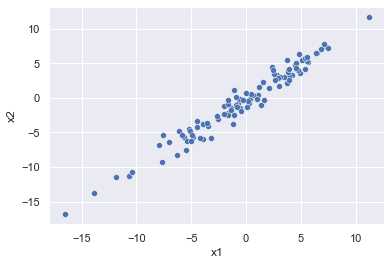

In [54]:
sns.scatterplot(data=tb_simul_x, x="x1", y="x2")


Para utilizarmos o algoritmo PCA precisamos garantir que nossos dados estão **normalizados**. Para tanto, utilizaremos o `StandardScaler` da biblioteca `sklearn`:

In [8]:
from sklearn.preprocessing import StandardScaler


In [9]:
scaler = StandardScaler()
scaler.fit(tb_simul_x)
X_norm = scaler.transform(tb_simul_x)


Agora que temos nossos dados normalizados, podemos aplicar o algoritmo à nossa tabela:

In [15]:
from sklearn.decomposition import PCA


In [16]:
pca = PCA(n_components=2)
pca.fit(X_norm)
pca_X_norm = pca.transform(X_norm)


O resultado do método `.transform` é a **transformação do dataset `X_norm`** utilizando o algoritmo PCA estimado a partir do **dataset `X_norm`** - como escolhemos 2 componentes, será uma matriz de duas colunas e com o mesmo número de pontos que `X_norm`:

In [17]:
pca_X_norm[0:5, :]


array([[-1.62113425, -0.06247735],
       [-0.13468636, -0.04105457],
       [ 2.95965434, -0.00580412],
       [-1.31499563, -0.03598296],
       [-0.0341649 , -0.11419334]])

Em varias aplicações, um array será suficiente. Mas para visualizar nossos componentes, podemos transformar este array em um `DataFrame` e junta-lo aos dados originais e normalizados:

In [22]:
tb_sca_x = pd.DataFrame(X_norm, columns=["X1_sca", "X2_sca"])
tb_pca_x = pd.DataFrame(pca_X_norm, columns=["PC1", "PC2"])
tb_full_x = pd.concat([tb_simul_x, tb_sca_x, tb_pca_x], axis=1)

tb_full_x.head()


,x1,x2,X1_sca,X2_sca,PC1,PC2
0,5.706270,5.226381,1.190493,1.102137,-1.621134,-0.062477
1,0.373313,-0.105121,0.124268,0.066208,-0.134686,-0.041055
2,-10.695259,-11.237726,-2.088688,-2.096896,2.959654,-0.005804
3,4.529831,4.208703,0.955286,0.904399,-1.314996,-0.035983
4,0.276467,-0.737104,0.104905,-0.056589,-0.034165,-0.114193


Podemos utilizar o atributo `.components` para visualizar os **loadings**: os coeficientes de combinação linear estimados para cada componente/variável:

In [29]:
components = pca.components_.T
components


array([[-0.70710678, -0.70710678],
       [-0.70710678,  0.70710678]])

Vamos converter o resultado disso em um `DataFrame` para ficar mais claro o que estamos vendo:

In [31]:
loadings = pd.DataFrame(components, columns=["PC1", "PC2"], index=tb_simul_x.columns)
loadings


,PC1,PC2
x1,-0.707107,-0.707107
x2,-0.707107,0.707107


Uma forma de entender PCA é pensar que os eixos X1 e X2 podem ser *rotacionados* e os nossos pontos de dados podem ser **projetados** sobre esses novos eixos. Para visualizar essa rotação vamos utilizar um tipo de *biplot*, que mostra como os eixos da PCA (os componentes `PC_0` e `PC_1`) estão em relação aos eixos originais:

Text(-0.8838834764831847, 0.8838834764831843, 'PC_1')

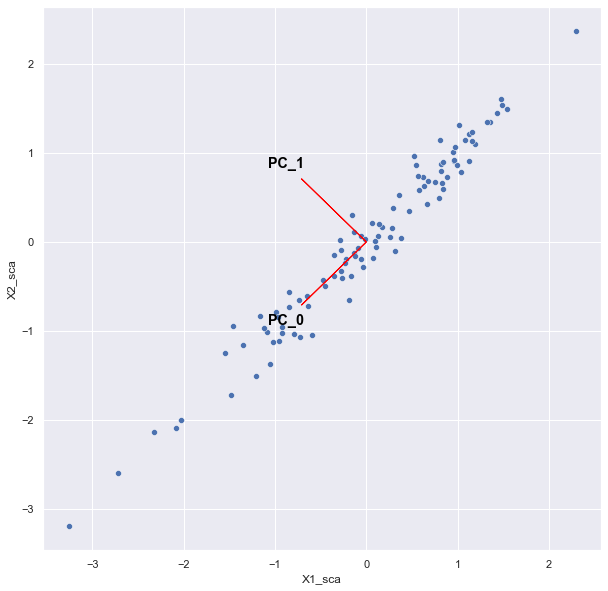

In [66]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=tb_full_x, x="X1_sca", y="X2_sca")
plt.arrow(0, 0, components[0, 0], components[1, 0], color="red")
plt.text(
    components[0, 0] * 1.25,
    components[1, 0] * 1.25,
    "PC_0",
    color="black",
    ha="center",
    va="center",
    fontsize="large",
    fontweight="bold",
)
plt.arrow(0, 0, components[0, 1], components[1, 1], color="red")
plt.text(
    components[0, 1] * 1.25,
    components[1, 1] * 1.25,
    "PC_1",
    color="black",
    ha="center",
    va="center",
    fontsize="large",
    fontweight="bold",
)


## Simulação II

The PCA algorithm will try to find the directions in which the most information is contained. By information, we always mean to say - variance.

Rather than attempting to *predict* the y values from the x values, the unsupervised learning problem attempts to learn about the *relationship* between your features (your `X`).

In principal component analysis, this relationship is quantified by finding a list of the *principal axes* in the data, and using those axes to describe the dataset.

In [69]:
def simular_dado_mv(parametros_x1, parametros_x2, desvpad_E, samples):
    x1 = np.random.normal(loc=parametros_x1[0], scale=parametros_x1[1], size=samples)
    x2 = x1 + np.random.normal(
        loc=parametros_x2[0], scale=parametros_x2[1], size=samples
    )
    E = np.random.normal(loc=0, scale=desvpad_E, size=samples)
    y = parametros_x1[2] * x1 + parametros_x2[2] * x2 + E
    x3 = (desvpad_E / 2) * y + np.random.normal(
        loc=0, scale=desvpad_E * 3, size=samples
    )
    return pd.DataFrame({"y": y, "X1": x1, "X2": x2, "X3": x3})


tb_sim = simular_dado_mv((0, 10, 2), (0, 5, -2), 4, 100)
tb_sim.head()


,y,X1,X2,X3
0,5.802980,-1.880459,-4.074241,28.636890
1,-1.280853,9.775457,9.257317,-15.756229
2,-2.362400,-10.209071,-8.561628,-7.720112
3,21.218191,8.482822,-2.062308,23.262003
4,-9.398985,4.397970,8.106562,-26.605772


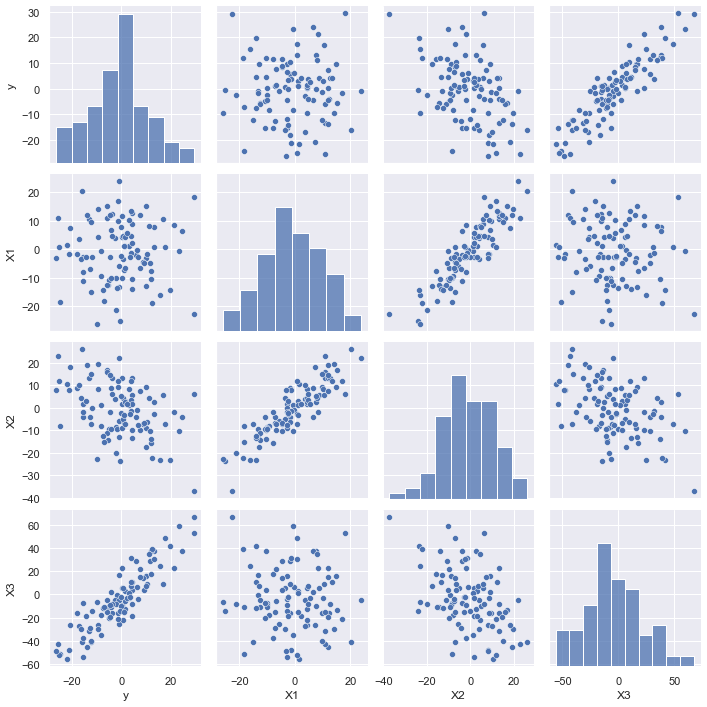

In [70]:
sns.pairplot(tb_sim)


Vamos criar duas regressões para estimar a relação entre as variáveis X e y de nosso dataset:

1. A variável `X3` parece ser a mais correlata com nossa variável resposta, então vamos utilizar uma regressão simples com `X3` como variável de entrada e `y` como variável resposta;
1. Vamos construir uma segunda regressão utilizando `X1` e `X2` como variáveis de entrada e `y` como variável resposta.

Para mensurar a capacidade preditiva de cada uma desses features, vamos utilizar o RMSE destas duas regressões.

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [85]:
X = tb_sim[["X3"]]
y = tb_sim["y"]
fit_x3 = LinearRegression()
fit_x3.fit(X, y)


LinearRegression()

Vamos calcular o erro desta primeira regressão:

In [86]:
rmse_x3 = np.sqrt(mean_squared_error(y, fit_x3.predict(X)))
print(np.round(rmse_x3, 2))


5.19


In [87]:
X = tb_sim[["X1", "X2"]]
y = tb_sim["y"]
fit_x1x2 = LinearRegression()
fit_x1x2.fit(X, y)


LinearRegression()

Agora, vamos calcular o erro de nossa segunda regressão:

In [90]:
rmse_x1x2 = np.sqrt(mean_squared_error(y, fit_x1x2.predict(X)))
print(np.round(rmse_x1x2, 2))


3.72


Embora a correlação entre `X3` e `y` seja maior que as correlações de `X1` e `X2`, a segunda regressão apresentou um erro bem inferior à primeira. O que está acontencendo? Vamos analisar os coeficientes de nossa segunda regressão para entender melhor:

In [93]:
fit_x1x2.coef_


array([ 2.10921834, -2.13188583])

In [94]:
tb_sim.corr()


,y,X1,X2,X3
y,1.000000,-0.004588,-0.432765,0.900477
X1,-0.004588,1.000000,0.892405,-0.089404
X2,-0.432765,0.892405,1.000000,-0.457202
X3,0.900477,-0.089404,-0.457202,1.000000


Nas duas tabelas acima podemos ver duas coisas:

1. `X1` e `y` são diretamente proporcionais enquanto `X2` e `y` são inversamente proporcionais;
1. `X1` e `X2` são positivamente correlatos.

Quando visualizamos as relações entre essas três variáveis a correlação entre `X1` e `X2` *oculta* a relação destas com `y`! Na prática, esse tipo de redundância pode nos levar à uma avaliação errônea das variáveis importantes de nosso dataset quando utilizamos comparações um à um de nossas variáveis!

Vamos utilizar PCA para remover a estrutura de correlação de nossas variáveis de entrada antes de alimentarmos ao nosso modelo:

In [96]:
norm = StandardScaler()
norm.fit(tb_sim[["X1", "X2"]])

norm_x1x2 = norm.transform(tb_sim[["X1", "X2"]])


In [97]:
pca_t = PCA(n_components=2)
pca_t.fit(norm_x1x2)


PCA(n_components=2)

In [103]:
X_pca = pd.DataFrame(pca_t.transform(norm_x1x2), columns=["PC0", "PC1"])
tb_sim_pca = pd.concat([tb_sim, X_pca], axis=1)
tb_sim_pca.head()


,y,X1,X2,X3,PC0,PC1
0,5.802980,-1.880459,-4.074241,28.636890,0.269891,0.130676
1,-1.280853,9.775457,9.257317,-15.756229,-1.308590,0.108003
2,-2.362400,-10.209071,-8.561628,-7.720112,1.095207,-0.155694
3,21.218191,8.482822,-2.062308,23.262003,-0.542563,0.701491
4,-9.398985,4.397970,8.106562,-26.605772,-0.880598,-0.181781


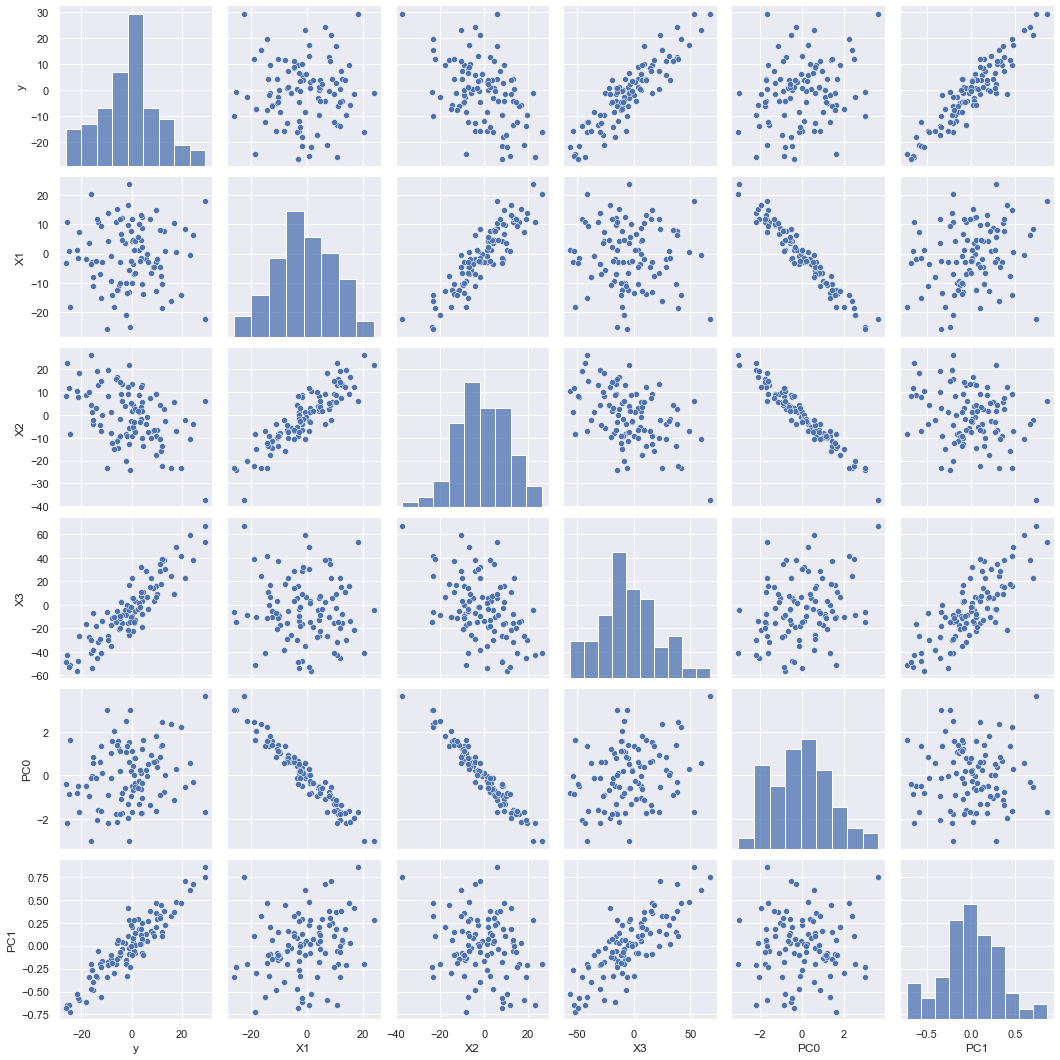

In [104]:
sns.pairplot(tb_sim_pca)


In [107]:
loadings = pd.DataFrame(pca_t.components_.T, columns=["PC1", "PC2"], index=["X1", "X2"])
loadings


,PC1,PC2
X1,-0.707107,0.707107
X2,-0.707107,-0.707107


## Aplicação I: Diamantes

Até agora vimos como PCA pode ser utilizada para transformar nossas variáveis em novas variáveis, busca simplificar a estrutura de correlação entre nossas variáveis X. 

Na segunda simulação, vimos como utilizando PCA conseguimos *desvendar* certas relações que estão escondidas pela correlação entre variáveis de entrada.

Agora, vamos utilizar *PCA para simplificar* um conjunto de dados com o qual trabalhamos: **diamantes**!

### Etapa 1: Carregar e transformar os Dados

Vamos utilizar uma função pré-definida (que vimos na apresentação das soluções do projeto) para ler e transformar nossos dados, criando alguns features a partir das sugestões do *notebook* da solução:

In [221]:
def etl_diamonds(diamonds):
    print("Linhas na base original:", str(len(diamonds)))
    x_0 = diamonds["x"] == 0
    y_0 = diamonds["y"] == 0
    z_0 = diamonds["z"] == 0
    dim_0 = x_0 | y_0 | z_0
    diamonds_c = diamonds[~dim_0].copy()
    dict_clarity = {
        "I1": 0,
        "SI2": 1,
        "SI1": 2,
        "VS2": 3,
        "VS1": 4,
        "VVS2": 5,
        "VVS1": 6,
        "IF": 7,
    }
    diamonds_c["clarity_num"] = diamonds_c["clarity"].map(dict_clarity)
    dict_color = {
        "D": 0,
        "E": 1,
        "F": 2,
        "G": 3,
        "H": 4,
        "I": 5,
        "J": 6,
    }
    diamonds_c["color_num"] = diamonds_c["color"].map(dict_color)
    dict_cut = {
        "Fair": 0,
        "Good": 1,
        "Very Good": 2,
        "Premium": 3,
        "Ideal": 4,
    }
    diamonds_c["cut_num"] = diamonds_c["cut"].map(dict_cut)
    diamonds_c["volume"] = diamonds_c["x"] * diamonds_c["y"] * diamonds_c["z"]
    diamonds_c["density"] = diamonds_c["carat"] / diamonds_c["volume"]
    density_inf = np.quantile(diamonds_c["density"], 0.01)
    density_sup = np.quantile(diamonds_c["density"], 0.99)
    density_in = (density_inf < diamonds_c["density"]) & (
        diamonds_c["density"] < density_sup
    )
    diamonds_c = diamonds_c[density_in].copy()

    diamonds_c["log_carat"] = np.log(diamonds_c["carat"])
    diamonds_c["log_price"] = np.log(diamonds_c["price"])
    diamonds_c = diamonds_c.drop(
        ["cut", "color", "price", "clarity", "density", "carat", "clarity", "volume", "density"], axis=1
    ).reset_index()
    print("Linhas na etapa atual:", str(len(diamonds_c)))
    return diamonds_c


In [222]:
tb_diamonds = pd.read_csv("data/tb_diamantes.csv")
tb_diamonds_c = etl_diamonds(tb_diamonds)
tb_diamonds_c.head()


Linhas na base original: 48940
Linhas na etapa atual: 47942


,index,depth,table,x,y,z,clarity_num,color_num,cut_num,log_carat,log_price
0,0,59.8,61.0,3.89,3.84,2.31,2,1,3,-1.560648,5.786897
1,1,56.9,65.0,4.05,4.07,2.31,4,1,1,-1.469676,5.789960
2,2,62.4,58.0,4.20,4.23,2.63,3,5,3,-1.237874,5.811141
3,3,63.3,58.0,4.34,4.35,2.75,1,6,1,-1.171183,5.814131
4,4,62.8,57.0,3.94,3.96,2.48,5,6,2,-1.427116,5.817111


In [225]:
X_var = [
    "depth",
    "table",
    "x",
    "y",
    "z",
    "clarity_num",
    "color_num",
    "cut_num",
    "log_carat",
]
y_var = "log_price"


A função acima converteu todas as variáveis categóricas originais em variáveis ordinais. Nosso dataset após as transformações e limpezas contém apenas variáveis numéricas e sem NAs

### Etapa 2: Normalizar os dados

Como vamos utilizar PCA, precisamos *normalizar* nossos dados. Vamos construir um `StandardScaler` para as nossas variáveis de entrada.

In [226]:
norm = StandardScaler()
norm.fit(tb_diamonds_c[X_var])

tb_diamonds_norm = pd.DataFrame(norm.transform(tb_diamonds_c[X_var]), columns=X_var)
tb_diamonds_norm['log_price'] = tb_diamonds_c['log_price']
tb_diamonds_norm.head()


,depth,table,x,y,z,clarity_num,color_num,cut_num,log_carat,log_price
0,-1.421635,1.617202,-1.643366,-1.701697,-1.780408,-0.645939,-0.936581,0.064792,-1.995017,5.786897
1,-3.546760,3.430983,-1.500458,-1.494882,-1.780408,0.573978,-0.936581,-1.759212,-1.839134,5.789960
2,0.483649,0.256866,-1.366482,-1.351011,-1.316414,-0.035980,1.416104,0.064792,-1.441937,5.811141
3,1.143170,0.256866,-1.241437,-1.243107,-1.142416,-1.255897,2.004275,-1.759212,-1.327660,5.814131
4,0.776769,-0.196579,-1.598707,-1.593793,-1.533911,1.183937,2.004275,-0.847210,-1.766207,5.817111


Vamos visualizar nossa matriz de correlação para entender se podemos ter problemas de colinearidade entre as variáveis de entrada:

<AxesSubplot:>

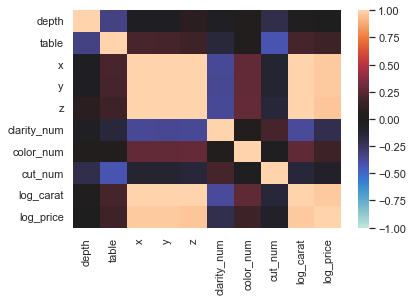

In [227]:
sns.heatmap(tb_diamonds_norm.corr(), vmin=-1, vmax=1, center=0)


### Etapa 3: Utilizando PCA

Com nosso dataset limpo e normalizado, podemos utilizar PCA para **estimar a quantidade real de informação que temos**: *features* altamente correlatas **são redundantes** e **ocultam relações com nossa variável resposta**!

In [229]:
X = tb_diamonds_norm.drop("log_price", axis=1)
pca_t = PCA()
pca_t.fit(X)
pca_X_norm = pca_t.transform(X)


Além de estimar os componentes, o algoritmo de PCA calcula **a % de informação sobre o dataset original está contida em cada componente**. Podemos acessar essa informação através do atributo `.explained_variance_ratio`:

In [230]:
[np.round(x, 2) for x in pca_t.explained_variance_ratio_]


[0.48, 0.16, 0.14, 0.11, 0.08, 0.04, 0.0, 0.0, 0.0]

Como podemos ver acima, o primeiro componente representa, sozinho, **53% da informação contida nas 9 variáveis originais!** Uma forma comum de avaliar o número de componentes que devemos utilizar em nossa análise é através do *scree plot*:

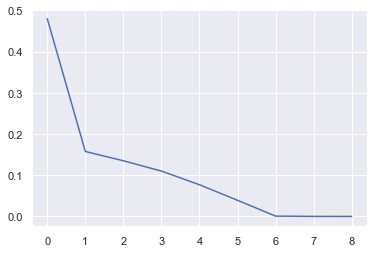

In [232]:
plt.plot(pca_t.explained_variance_ratio_)


O *scree plot* acima nos mostra que a partir do segundo cada componente adicional representa muito pouca informação. Vamos utilizar esta leitura para inicializar nosso PCA com apenas 2 componentes através do argumento `n_components`

In [233]:
X = tb_diamonds_norm.drop("log_price", axis=1)
pca_t = PCA(n_components=2)
pca_t.fit(X)


PCA(n_components=2)

In [234]:
tb_pca_diam = pd.DataFrame(
    pca_t.transform(X), columns=["PC_" + str(i) for i in range(pca_t.n_components_)]
)

tb_pca_diam["log_price"] = tb_diamonds_norm["log_price"]
tb_pca_diam.head()


,PC_0,PC_1,log_price
0,-3.173421,2.446398,5.786897
1,-2.777425,5.133304,5.789960
2,-2.347901,0.202170,5.811141
3,-1.549938,1.064447,5.814131
4,-2.974993,0.045629,5.817111


### Etapa 4: Análise

### Análise de Loadings

In [235]:
loadings = pd.DataFrame(pca_t.components_.T, columns=["PC_0", "PC_1"], index=X.columns)
loadings


,PC_0,PC_1
depth,-0.002340,-0.305628
table,0.127751,0.713064
x,0.474757,-0.073911
y,0.474318,-0.076630
z,0.473490,-0.111309
clarity_num,-0.222582,-0.179260
color_num,0.152823,-0.187539
cut_num,-0.104669,-0.548847
log_carat,0.474611,-0.076603


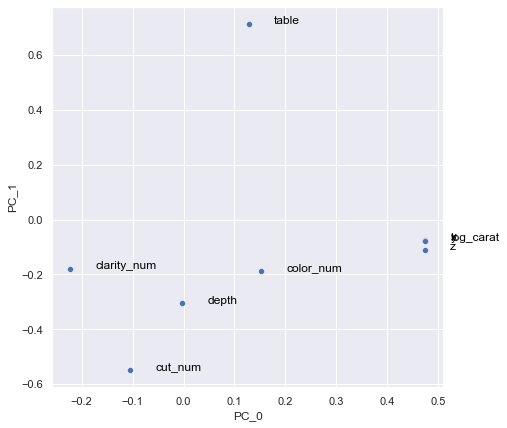

In [236]:
plt.figure(figsize=(7, 7))
p1 = sns.scatterplot(data=loadings, x="PC_0", y="PC_1")
for line in range(0, loadings.shape[0]):
    p1.text(
        loadings.iloc[line, 0] + 0.05,
        loadings.iloc[line, 1],
        loadings.index[line],
        horizontalalignment="left",
        size="medium",
        color="black",
    )


#### Visualização de dados

<AxesSubplot:xlabel='PC_0', ylabel='log_price'>

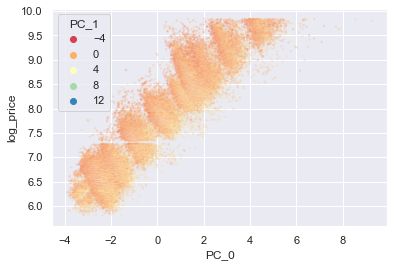

In [241]:
sns.scatterplot(data=tb_pca_diam, x="PC_0", y="log_price", hue="PC_1", palette = 'Spectral', s = 5, alpha = 0.2)


Com a análise acima podemos concluir que as informações são altamente redundantes - apenas o componente 0 apresenta correlação direta com a variável resposta. Sabendo isto, poderíamos ou buscar mais informações ou voltar ao processo de exploração de dados para construir novos *features* (discretizando variáveis continuas por exemplo) ou explorar nossos *features* categóricos.

## Aplicação 2: NLP

Além da importância no processo de exploração, PCA pode ser utilizado para reduzir informações antes de utiliza-las em um modelo. Uma forma comum desta utilização acontece quando temos mais features do que pontos - algo comum nas tarefas de NLP (*natural language processing*).

Vamos utilizar PCA para construir uma regressão capaz de prever a quantidade de gordura em uma tabela de ingredientes a partir da **descrição deste ingrediente**

### Carregando dados

In [283]:
food = pd.read_csv("data/Food Composition.csv")
food = food[food['Fat Factor'] > 0].copy()
food.head()

,Public Food Key,Food Profile ID,Derivation,Food Name,Food Description,Sampling Details,Nitrogen Factor,Fat Factor,Specific Gravity,Analysed Portion,Unanalysed Portion,Classification,Classification Name
0,F002258,14723,Borrowed,"Cardamom seed, dried, ground",Ground spice commonly used in Indian cooking a...,The majority of nutrient data were borrowed fr...,6.25,0.96,0.0,100%,0%,31302,Herbs(dried) and spices
1,F002963,14718,Borrowed,"Cinnamon, dried, ground",Dried and ground bark or quills of Cinnamomum ...,The majority of nutrient data were borrowed fr...,6.25,0.96,0.0,100%,0%,31302,Herbs(dried) and spices
2,F002970,14725,Borrowed,"Cloves, dried, ground","Dried and ground, unopened flower buds of Syzy...",The majority of nutrient data were borrowed fr...,6.25,0.96,0.0,100%,0%,31302,Herbs(dried) and spices
3,F003190,14727,Borrowed,"Coriander seed, dried, ground",Dried and ground fruit or seed of Coriandrum s...,The majority of nutrient data were borrowed fr...,6.25,0.96,0.0,100%,0%,31302,Herbs(dried) and spices
4,F003327,14728,Borrowed,"Cumin (cummin) seed, dried, ground",Dried and ground fruit or seeds of Cuminum cym...,The majority of nutrient data were borrowed fr...,6.25,0.96,0.0,100%,0%,31302,Herbs(dried) and spices


Vamos criar um campo novo a partir da concatenação das variáveis `Food Name` e `Food Description`

In [284]:
food["text"] = food["Food Name"] + " " + food["Food Description"]


### Conhecendo o CountVectorizer

Para trabalharmos com texto (texto livre, não categorias) precisamos buscar alguma estratégia para transformar este texto em variáveis numéricas. Uma forma simples é através do modelo *Bag-of-Word*: vamos criar uma coluna numérica para cada palavra que aparece em nossas descrições. Essa coluna conterá o número de ocorrências de sua palavra em cada um de nossos textos.

Para construir essa matriz podemos utilizar o `CountVectorizer` da `sklearn`:

In [285]:
from sklearn.feature_extraction.text import CountVectorizer

O `CountVectorizer` se comporta como o `StandardScaler`: ele possui um método `.fit()` e um método `.transform()`. Vamos utilizar esses dois métodos para encontrar nossa matriz de *bag-of-words*:

In [286]:
ck = CountVectorizer(stop_words="english")
ck_fit = ck.fit(food["text"])
X = ck_fit.transform(food["text"]).toarray()
X.shape

(1045, 2048)

Podemos transformar X em um DataFrame, mas como não vamos visualiza-lo diretamente (**2094** colunas!) esta etapa não é necessária.

### Reduzindo o vocabulário

O número de colunas é muito grande e provavelmente cheio de colinearidades. Como o dataset é grande demais para visualizarmos, precisaremos utilizar uma redução dimensional antes de alimentar estes dados ao nosso modelo.

Vamos utilizar nosso *scree plot* para escolher o número de componentes em nosso PCA:


In [287]:
norm = StandardScaler()
norm.fit(X)

X_sca = norm.transform(X)

In [288]:
pca_t = PCA()
pca_t.fit(X_sca)


PCA()

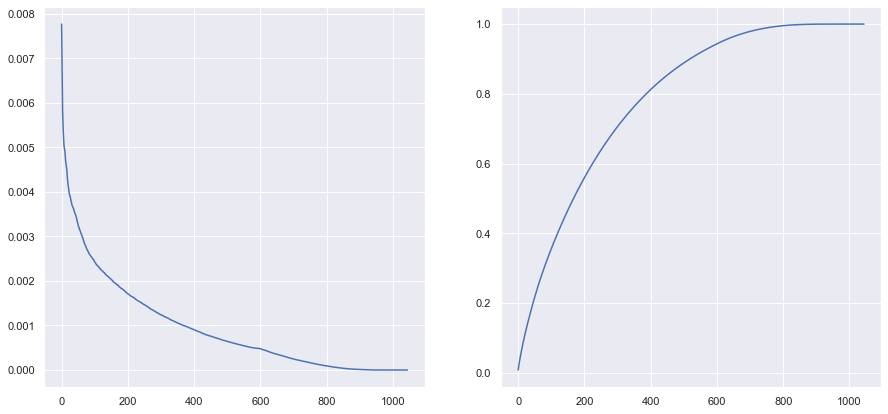

In [289]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
ax[0].plot(pca_t.explained_variance_ratio_)
ax[1].plot(np.cumsum(pca_t.explained_variance_ratio_))

Pelos gráficos acima podemos ver que a partir de **800 componentes** não temos quase nenhuma informação adicional. Entretanto, temos apenas **1045** linhas de dados - um modelo com 800 variáveis ainda tem variáveis demais!

Olhando para o *scree plot** podemos ver que a quantidade de informação adicional cai radicalmente após cerca de 190 componentes. Vamos testar um modelo com este número e avaliar o erro:

In [336]:
pca_t = PCA(n_components=190)
pca_t.fit(X_sca)


PCA(n_components=190)

Os loadings de uma redução dimensional do modelo *bag-of-words* representam um modelo **muito comum** em NLP: **o modelo de tópicos**. Vamos ordernar nossa tabela de loadings por alguns de nossos componentes para visualizar o que é um modelo de tópicos:

In [337]:
loadings = pd.DataFrame(pca_t.components_.T, index=ck.get_feature_names_out())
loadings.sort_values(1, ascending=False).head(10)


,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
hops,0.083064,0.215522,0.060556,0.004604,-0.095615,0.024480,0.014249,0.008353,-0.004830,0.001161,...,-0.006658,-0.007987,-0.000610,-0.009658,-0.000004,-0.006109,0.000843,0.001771,0.000211,0.010196
preparations,0.083064,0.215522,0.060556,0.004604,-0.095615,0.024480,0.014249,0.008353,-0.004830,0.001161,...,-0.006658,-0.007987,-0.000610,-0.009658,-0.000004,-0.006109,0.000843,0.001771,0.000211,0.010196
presence,0.083064,0.215522,0.060556,0.004604,-0.095615,0.024480,0.014249,0.008353,-0.004830,0.001161,...,-0.006658,-0.007987,-0.000610,-0.009658,-0.000004,-0.006109,0.000843,0.001771,0.000211,0.010196
unmalted,0.083064,0.215522,0.060556,0.004604,-0.095615,0.024480,0.014249,0.008353,-0.004830,0.001161,...,-0.006658,-0.007987,-0.000610,-0.009658,-0.000004,-0.006109,0.000843,0.001771,0.000211,0.010196
aqueous,0.083064,0.215522,0.060556,0.004604,-0.095615,0.024480,0.014249,0.008353,-0.004830,0.001161,...,-0.006658,-0.007987,-0.000610,-0.009658,-0.000004,-0.006109,0.000843,0.001771,0.000211,0.010196
alcohol,0.091095,0.212596,0.032360,-0.003266,0.009269,-0.014872,0.009544,-0.019030,0.036962,-0.013648,...,-0.019378,0.005290,0.011189,-0.004773,-0.006313,0.010510,0.006762,-0.010008,-0.002770,0.010872
malted,0.083689,0.197524,0.069434,0.000970,-0.086689,0.021419,0.007328,0.008115,-0.004470,0.004355,...,-0.012485,0.009433,-0.020105,-0.001434,0.015407,-0.014982,0.003175,0.025042,0.015598,-0.013333
beer,0.075779,0.195628,0.054318,0.003875,-0.087885,0.025354,0.014124,0.007128,-0.007286,0.001546,...,0.001913,-0.020123,0.001526,-0.004087,0.014526,0.002095,0.005126,-0.001476,-0.007079,0.011512
fermentation,0.084882,0.190150,0.016279,-0.008662,0.042783,-0.027387,0.017794,-0.056682,0.072475,-0.023772,...,-0.012095,0.005698,0.002899,-0.011142,-0.001851,0.000505,0.000210,0.003310,0.004590,0.010082
cereals,0.081856,0.181687,0.053889,0.003684,-0.006147,-0.018046,-0.027140,0.103507,-0.040421,0.004397,...,-0.000241,0.011179,-0.022562,-0.001018,0.017166,-0.026314,0.000873,0.025831,0.018732,-0.012649


### Modelando

Com nossas novas variáveis podemos modelar a variável `Fat Factor` utilizando nossos componentes, criados a partir das descrições dos ingredientes:

In [338]:
X_pca = pca_t.transform(X_sca)
y = food["Fat Factor"]

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state = 42)


In [339]:
reg_fit = LinearRegression()
reg_fit.fit(X_train, y_train)


LinearRegression()

In [340]:
fat_pred = reg_fit.predict(X_test)
rmse_fat = np.sqrt(mean_squared_error(y_test, fat_pred))

print(np.round(rmse_fat, 2))

0.11


Podemos visualizar o modelo através de um *scatterplot* comparando previsões com valores reais no conjunto de teste:

<AxesSubplot:ylabel='Fat Factor'>

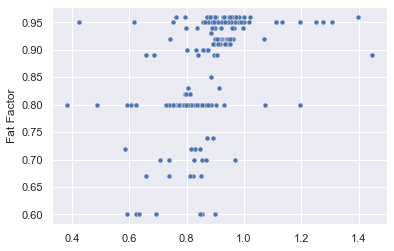

In [341]:
sns.scatterplot(x = fat_pred, y = y_test, s = 25)

Agora, vamos testar com menos componentes:

In [343]:
pca_t = PCA(n_components=30)
pca_t.fit(X_sca)
X_pca = pca_t.transform(X_sca)
y = food["Fat Factor"]

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state = 42)
reg_fit = LinearRegression()
reg_fit.fit(X_train, y_train)

fat_pred = reg_fit.predict(X_test)
rmse_fat = np.sqrt(mean_squared_error(y_test, fat_pred))

print(np.round(rmse_fat, 2))

0.08


<AxesSubplot:ylabel='Fat Factor'>

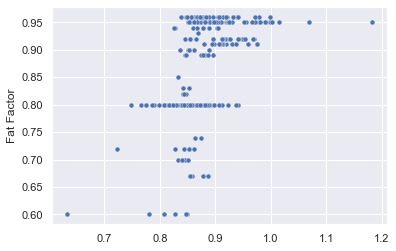

In [344]:
sns.scatterplot(x = fat_pred, y = y_test, s = 25)